In [3]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, evidence_meta_diffusion
from src.python.helpers import load_empirical_rt_data
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Application to empirical data

## Load in data

In [4]:
# Load data from folders

parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(parent_folder, 'data\\Levy_flight_application\\data_rts\\color')
lexical_folder = os.path.join(parent_folder, 'data\\Levy_flight_application\\data_rts\\lexical')

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

In [5]:
# Join experimental data and fill missing values

n_clusters = len(color_data)
empirical_data = []

for j in range(n_clusters):
    joint_data = tf.concat([color_data[j], lexical_data[j]], axis=2).numpy()
    npad = ((0,0), (0,0), (0,900-joint_data.shape[2]), (0,0))
    joint_data = np.pad(joint_data, npad,  'constant', constant_values=-1)
    empirical_data.append(joint_data)

# Transform to np.array
empirical_data = np.reshape(np.asarray(empirical_data), (1,40,900,3))

# Assert that the number of coded missings equals the real number of missings
(empirical_data == -1).sum()/(40*3)

28.525

[0.188 0.188 0.189 0.196 0.197 0.197 0.197 0.198 0.198]
[4.001 4.009 4.041 4.097 4.114 4.12  4.206 4.287 4.289 4.304 4.346 4.401
 4.423 4.561 4.631 4.647 4.727]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

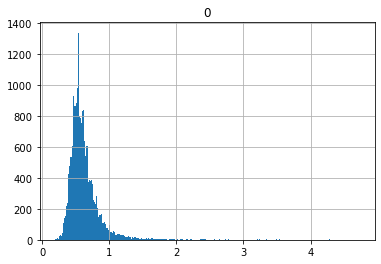

In [6]:
# Check RTs
rts = empirical_data[:,:,:,1]
rts = rts[rts > 0]
rts.sort()
print(rts[rts < .2])
print(rts[rts > 4])
pd.DataFrame(rts).hist(bins=500)

## Load in trained network

In [7]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
evidence_net = EvidentialNetwork(evidence_meta_diffusion)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'trial_2'
checkpoint_path = os.path.join(os.getcwd(), 'training_checkpoints', trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\03_levy_flight_application\training_checkpoints\trial_2\ckpt-64


## Predict

In [8]:
labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]
           
preds = evidence_net.predict(summary_net(empirical_data))
preds

{'m_probs': array([[0.00125332, 0.00125332, 0.00125332, 0.99624   ]], dtype=float32),
 'm_var': array([[0.00000157, 0.00000157, 0.00000157, 0.00000469]], dtype=float32),
 'uncertainty': array([[0.00501327]], dtype=float32)}

In [9]:
pd.DataFrame(preds['m_probs'], index=['Posterior model probability'], columns=labels)

,Basic Diffusion Model,Basic Lévy Flight Model,Full Diffusion Model,Full Lévy Flight Model
Posterior model probability,0.001253,0.001253,0.001253,0.99624


In [10]:
bfs = [prob/preds['m_probs'][0][3] for prob in preds['m_probs']]
pd.DataFrame(bfs, index=['Bayes factor'], columns=labels)

,Basic Diffusion Model,Basic Lévy Flight Model,Full Diffusion Model,Full Lévy Flight Model
Bayes factor,0.001258,0.001258,0.001258,1.0


In [11]:
evidences = evidence_net(summary_net(empirical_data))
dirichlet = evidence_net.sample(summary_net(empirical_data),10000)
dirichlet = np.squeeze(dirichlet)

Text(0, 0.5, 'Approximated posterior model probability')

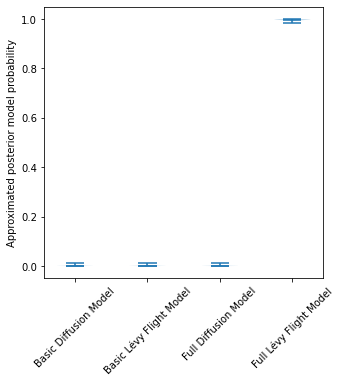

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

ax.violinplot(dirichlet, showmedians=True)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Approximated posterior model probability')
#fig.savefig('Diffusion_violin_plot.png', dpi=300, bbox_inches='tight')